In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import random
from playlist import *
from collections import defaultdict
from numpy.random import choice
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# client_credentials_manager = SpotifyClientCredentials()
# sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# results = sp.search(q='weezer', limit=20)
# for i, t in enumerate(results['tracks']['items']):
#     print(' ', i, t['name'])

In [127]:
playlist_list = get_playlist_list()

In [145]:
def get_tracks(playlist):
    track_list = set([])
    for i in range(playlist['num_tracks']):
        track_list.add(playlist['tracks'][i]['track_uri'])
    return track_list

In [146]:
# track_audio_features = {}
# for i in range (len(playlist_list)):
#         playlist = playlist_list[i]
#         for j in range(playlist['num_tracks']):
#             track_uri = playlist['tracks'][j]['track_uri']
#             if track_uri not in track_audio_features:
#                 track_audio_features[track_uri] = sp.audio_features([track_uri])[0]

In [19]:
# import gzip
# import pickle

# with gzip.open('audio_features_1K.pickle.gz','wb') as output:
#     pickle.dump(track_audio_features ,output)

In [147]:
import gzip
import pickle

with gzip.open("audio_features_1K_p2.pickle.gz", "rb") as inp:
    track_audio_features = pickle.load(inp)

In [148]:

# sp.audio_features(['spotify:track:20ORwCJusz4KS2PbTPVNKo'])

In [149]:
# sp.audio_analysis('spotify:track:20ORwCJusz4KS2PbTPVNKo')

In [150]:
# sp.artist('spotify:artist:2Hjj68yyUPiC0HKEOigcEp')

In [151]:
audio_df = pd.DataFrame(track_audio_features).T
audio_df = audio_df[['acousticness', 'danceability', 'duration_ms', 'energy',
        'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature',
       'valence']]
audio_df = audio_df.astype(float)

In [152]:
audio_df.shape

(34443, 13)

In [153]:
audio_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
spotify:track:000mA0etY38nKdvf1N04af,0.2530,0.300,214507.0,0.630,0.000005,10.0,0.1320,-8.406,1.0,0.0384,77.570,4.0,0.182
spotify:track:000xQL6tZNLJzIrtIgxqSl,0.1310,0.748,188491.0,0.627,0.000000,7.0,0.0852,-6.029,1.0,0.0644,120.963,4.0,0.524
spotify:track:006AVH7fq061voGXkUiII4,0.6970,0.491,191573.0,0.324,0.000000,2.0,0.1350,-10.627,1.0,0.0442,115.137,5.0,0.123
spotify:track:006PJvsr6CyV3JdBf7wiNF,0.1620,0.861,305320.0,0.417,0.000028,0.0,0.1020,-8.083,0.0,0.0437,119.968,4.0,0.235
spotify:track:006yrnQMCZpiUgkR612gC8,0.0529,0.751,123411.0,0.829,0.000076,10.0,0.4980,-2.007,0.0,0.1090,140.118,4.0,0.275


In [154]:
audio_df = audio_df.fillna(0)

In [155]:
# normalised panda data frame
from sklearn import preprocessing

x = audio_df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
new_audio_df = pd.DataFrame(x_scaled)
new_audio_df.index = audio_df.index
audio_df = new_audio_df
# new_audio_df.head()

In [156]:
def get_track_embedding(track_uri):
    return audio_df.loc[track_uri].values

In [157]:
get_track_embedding('spotify:track:0uqPG793dkDDN7sCUJJIVC').shape

(13,)

In [158]:
cached_playlist_embedding = {}

def get_playlist_embedding(playlist_id):
    # check if already in cache 
    if playlist_id in cached_playlist_embedding:
        return cached_playlist_embedding[playlist_id]

    embedding_list = []
    for i in range(playlist_list[playlist_id]['num_tracks']):
        track_uri = playlist_list[playlist_id]['tracks'][i]['track_uri']
    #     print(type(track_df.loc[track_uri]))
        embedding_list.append(get_track_embedding(track_uri))
    embedding = np.mean(embedding_list, axis = 0)
    # put in the cache
    cached_playlist_embedding[playlist_id] = embedding
    return embedding

In [159]:
# get_playlist_embedding(0).shape

In [160]:
def cal_similarity(playlist_id_1, playlist_id_2):
#         similarity = sklearn.metrics.pairwise.cosine_similarity(get_playlist_embedding(playlist_id_1).reshape(1, -1), 
#                                                                 get_playlist_embedding(playlist_id_2).reshape(1, -1))
    similarity = sklearn.metrics.pairwise.euclidean_distances(get_playlist_embedding(playlist_id_1).reshape(1, -1), 
                                                                get_playlist_embedding(playlist_id_2).reshape(1, -1))
#         return similarity[0][0]
    return -similarity[0][0]

In [192]:
def biased_audio_random_walk_playlist(query,g, beta = 10):
    
    N = 1000
    totSteps = 0
    nHighVisited = 0
    nt = 200
    nv = 5
    num_visits = defaultdict(int)
    
    def weight_cal(edge):
        weight = cal_similarity(query,edge)
        return weight

    while totSteps < N or nHighVisited > nt: 
        currPlaylist = query
        # Number of iterations
        currSteps = 5
        for i in range(currSteps):
            # takes 1 step (from a playlist to track)
            edges = list(g.GetNI(currPlaylist).GetOutEdges())
            currTrack = random.choice(edges)
            # takes 1 step (from a track to playlist)
            edges = list(g.GetNI(currTrack).GetOutEdges())
#             weights = [f(edge) for edge in edges]
            weights = [weight_cal(edge) for edge in edges]
            weights_np = np.asarray(weights)

# uncomment to do softmax
# see https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
#             # this bit makes it more stable numerically
            max_weight = np.max(weights_np)
            weights_np -= max_weight
            # but does not change the answer
            weights_np = np.exp(beta * weights_np)

            prob_dis = weights_np / float(sum(weights_np))
            currPlaylist = int(choice(edges, 1, p=prob_dis))
            num_visits[currTrack] += 1
            if num_visits[currTrack] == nv:
                nHighVisited += 1
        totSteps += currSteps
    return num_visits

In [193]:
def cal_most_visited_playlist(playlist_list, playlist_id):
    dropped_track_index = random.choice(range(len(playlist_list[playlist_id])))
#         for dropped_track_index in range(len(playlist_list[playlist_id])):
    g, dropped_track_id = make_graph_drop_edge(playlist_list, playlist_id, dropped_track_index)
#             print('1', playlist_id, dropped_track_id)
#             tracks in the playlist graphs where one is dropped
    if len(list(g.GetNI(playlist_id).GetOutEdges())) < 5:
        return None, None
    query = playlist_id
    num_visits = biased_audio_random_walk_playlist(query,g)
#     num_visits = highest_visited_random_walk_playlist(query, g)
#     num_visits =biased_modified_at_random_walk_playlist(query, g)
    suggested_ids = sorted(num_visits, key=num_visits.get, reverse=True)
    return dropped_track_id, suggested_ids

In [194]:
# all_true_ids, all_suggested_ids = cal_most_visited(playlist_list)
all_true_ids, all_suggested_ids = process_playlists(cal_most_visited_playlist, playlist_list, multiprocess=False)

In [ ]:

# np.any(audio_df.isna(), axis = 0)

In [ ]:
# help(audio_df.fillna)

In [195]:
avg_precision = cal_ave_precision(600, all_true_ids, all_suggested_ids)
print avg_precision

0.142421159715


In [65]:
import math
def dcg(gains):
    value = 0
    for index, gain in enumerate(gains):
        if index == 0:
            value += gain
        else:
            value += gain/math.log(1+index)
    return value

In [66]:
def ndcg(gains):
    ideal_gains = list(sorted(gains))     
    ideal_dcg = dcg(ideal_gains)
    if ideal_dcg == 0:
        return 0.0
    real_dcg = dcg(gains)
    return real_dcg/ideal_dcg

In [77]:
def get_gain(playlist_index, true_index, indices):
    gains = []
    for index in indices:
        if index == true_index:
            gains.append(2)
        elif is_same_playlist(track_playlists, true_index, index):
            gains.append(1)
        else:
            gains.append(0)
    return gains

In [73]:
def is_same_playlist(track_playlists, track1, track2):
    if track_playlists[track1].intersection(track_playlists[track2]):
        return True
    return False

In [74]:
from collections import defaultdict
def make_track_playlists(playlist_list):
    track_playlists = defaultdict(set)
    for playlist_index, playlist in enumerate(playlist_list):
        for track_uri in get_tracks(playlist):
            track_playlists[track_uri].add(playlist_index)
    return track_playlists

limited_playlist_list = playlist_list[:1000]
track_playlists = make_track_playlists(limited_playlist_list)

In [75]:
def cal_ndcg(track_playlists, all_true_indices, all_indices):
    result = 0
    count = 0
    for true_index, indices in zip(all_true_indices, all_indices):
        playlist_index = count
        gains = get_gain(playlist_index, true_index, indices[0,:])
        result += ndcg(gains)
        count += 1
    return result / count

In [76]:
all_suggested_ids_np = [np.array(all_suggested_id).reshape(1,-1)
                        for all_suggested_id in all_suggested_ids]
cal_ndcg(track_playlists, all_true_ids, all_suggested_ids_np)

0.24178949260357807

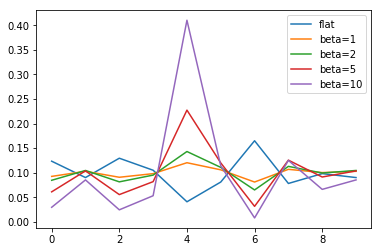

In [191]:
import matplotlib.pyplot as plt

weights = [cal_similarity(0, 1+i) for i in range(10)]
weights_np = np.asarray(weights)
prob_dis = weights_np / float(sum(weights_np))
plt.plot(prob_dis, label="flat")
for beta in [1,2,5,10]:
    weights_np = np.asarray(weights)
    # this bit makes it more stable numerically
    max_weight = np.max(weights_np)
    weights_np -= max_weight
    # but does not change the answer
    weights_np = np.exp(beta * weights_np)

    prob_dis = weights_np / float(sum(weights_np))
    plt.plot(prob_dis, label="beta=" + str(beta))
plt.legend()
plt.show()

In [171]:
weights

[-0.39295434296111453,
 -0.28679903057623057,
 -0.41229439175583665,
 -0.33429634733961316,
 -0.12960032785052511,
 -0.25774752428243652,
 -0.52556115256711322,
 -0.24848170252534185,
 -0.31241152462882471,
 -0.28682671730932702]